In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [3]:
print(tf.__version__)
tf.config.list_physical_devices('GPU') # 실행하여 GPU가 인식된다면, 자동으로 GPU 연산 가능

2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
df = pd.read_csv('/home/miserver10/workspace_vscode/datasets/Vehicle.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Hour      1689 non-null   int64
 1   Vehicles  1689 non-null   int64
dtypes: int64(2)
memory usage: 26.5 KB


In [6]:
df.describe

<bound method NDFrame.describe of       Hour  Vehicles
0        1       699
1        2       346
2        3       193
3        4       191
4        5       193
...    ...       ...
1684  1685       194
1685  1686       373
1686  1687      1218
1687  1688      4076
1688  1689      5137

[1689 rows x 2 columns]>

In [8]:
df.set_index('Hour', inplace=True)

In [9]:
df['Vehicles_MA'] = df['Vehicles'].rolling(window=24*7).mean()

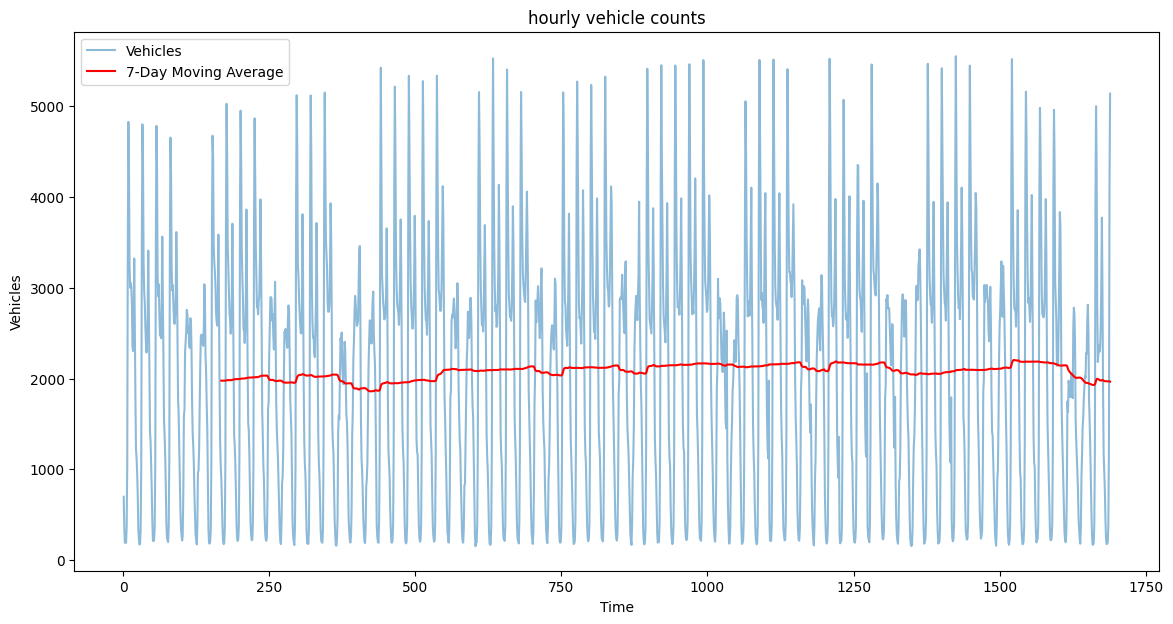

In [11]:
# 시각화
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Vehicles'], label='Vehicles', alpha=0.5)
plt.plot(df.index, df['Vehicles_MA'], label='7-Day Moving Average', color='red')
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.title('hourly vehicle counts')
plt.legend()
plt.show()

In [12]:
df.head()

,Vehicles,Vehicles_MA
Hour,,
1,699,NaN
2,346,NaN
3,193,NaN
4,191,NaN
5,193,NaN


In [16]:
# 데이터 전처리
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Vehicles']])

# 데이터 분할 (훈련과 테스트)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [17]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length, 0]
        label = data[i + sequence_length, 0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# seq : 과거 24개의 데이터, label : 다음 데이터인 label을 예측하고자 학습

sequence_length = 24   # 하루 단위로 예측
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [23]:
# 데이터를 3D 형태로 변환 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) 

In [24]:
# LSTM 모델 정의
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, batch_size=2, epochs=30)

2024-06-06 13:49:21.849897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 13:49:23.245285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5
2024-06-06 13:49:23.246111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10281 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1


Epoch 1/30


2024-06-06 13:49:27.683790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2024-06-06 13:49:28.517710: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x32b98ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 13:49:28.517784: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-06-06 13:49:28.517810: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-06 13:49:28.533175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 13:49:28.694466: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


664/664 [==============================] - 15s 15ms/step - loss: 0.0319
Epoch 2/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0103
Epoch 3/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0073
Epoch 4/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0064
Epoch 5/30
664/664 [==============================] - 10s 14ms/step - loss: 0.0057
Epoch 6/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0053
Epoch 7/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0051
Epoch 8/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0048
Epoch 9/30
664/664 [==============================] - 10s 14ms/step - loss: 0.0048
Epoch 10/30
664/664 [==============================] - 10s 15ms/step - loss: 0.0046
Epoch 11/30
664/664 [==============================] - 10s 14ms/step - loss: 0.0041
Epoch 12/30
664/664 [==============================] - 10s 14ms/step - loss: 0.0039
Epoch 13/30


10/10 [==============================] - 0s 5ms/step


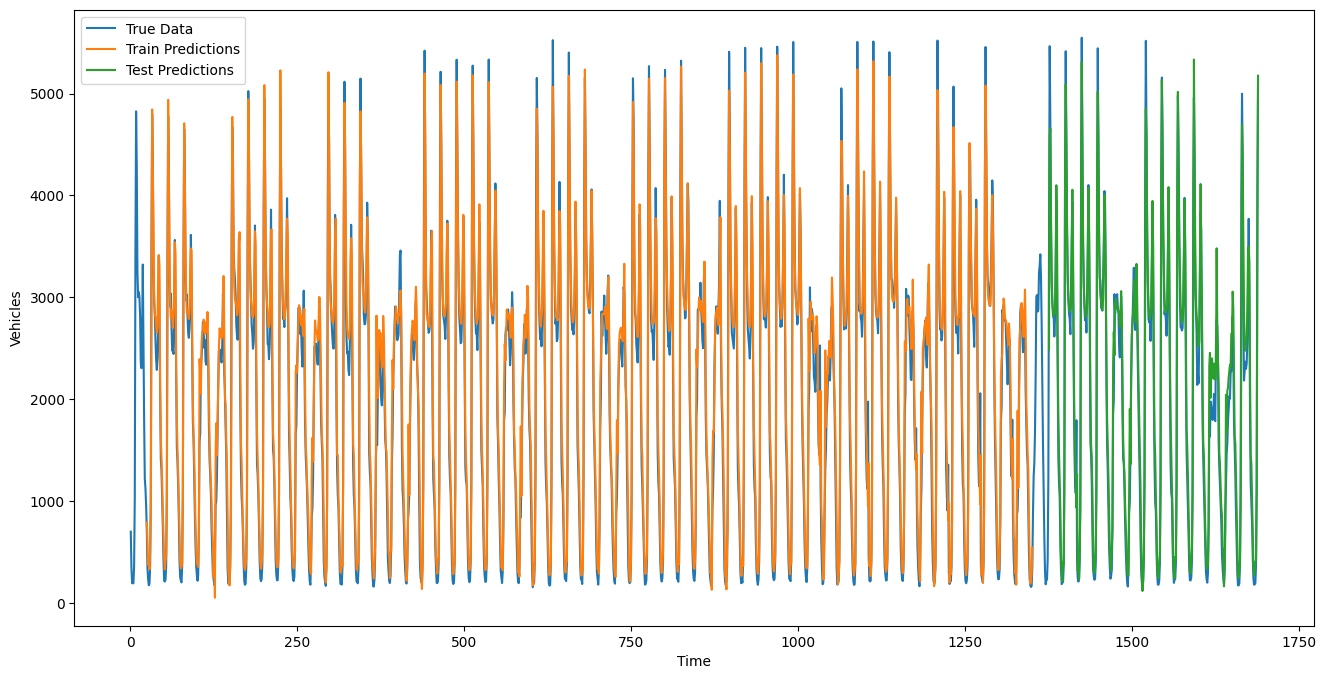

In [26]:
# 예측 수행
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# 원래 스케일로 변환
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 빈 배열 생성
train_predictions_plot = np.empty((len(df), 1))
train_predictions_plot[:, :] = np.nan
test_predictions_plot = np.empty((len(df), 1))
test_predictions_plot[:, :] = np.nan

# 예측값 할당
train_predictions_plot[sequence_length:len(train_predictions) + sequence_length, 0] = train_predictions[:, 0]
test_predictions_plot[sequence_length + len(train_predictions) + sequence_length:len(df) , 0] = test_predictions[:, 0]

# 데이터프레임에 예측값 추가
df['Train Predictions'] = train_predictions_plot
df['Test Predictions'] = test_predictions_plot

# 시각화
plt.figure(figsize=(16, 8))
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.plot(df.index, df['Vehicles'], label='True Data')
plt.plot(df.index, df['Train Predictions'], label='Train Predictions')
plt.plot(df.index, df['Test Predictions'], label='Test Predictions')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE 계산
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error (MSE): {mse}')

# MAE 계산
mae = mean_absolute_error(y_test, test_predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 94040.69313226282
Mean Absolute Error (MAE): 225.8323633959339
